# HarvestStat Data Analysis - Lesotho

## Issue 1: Year-off issue

In [1]:
# Reproduce year-off issue
import json, requests
import pandas as pd
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Lesotho',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df[
    (df['product'] == 'Maize Grain (White)') &
    (df['season_year'].isin(['Summer 2013','Summer 2014','Summer 2015','Summer 2016'])) &
    (df['indicator'] == 'Quantity Produced')
].pivot_table(index='admin_1',columns=['season_date','period_date'],values='value')

season_date,2013-08-01,2014-08-01,2015-08-01,2016-08-01
period_date,2014-01-31,2015-01-31,2016-01-31,2017-01-31
admin_1,,,,
Berea,13817.0,15515.0,6476.0,3173.0
Butha-Buthe,3180.0,2540.0,3343.0,1117.0
Leribe,13967.0,14319.0,18849.0,4285.0
Mafeteng,10069.0,10191.0,3001.0,348.0
Maseru,15671.0,15044.0,14873.0,4766.0
Mohale's Hoek,3529.0,11167.0,4068.0,1970.0
Mokhotlong,13493.0,10531.0,8197.0,3933.0
Qacha's Nek,1696.0,944.0,396.0,1607.0


## (Resoloved) Issue 2: duplicates between "publication_name"

In [11]:
# Reproduce duplicate data
import json, requests
import pandas as pd
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Lesotho',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
pub = [
    'Agricultural Production Survey, Crops, 2017-2018, Lesotho', 
    'Statistical Yearbook, 2008, Lesotho',
    'Agricultural Production Survey, Crops, 2007-2008, Lesotho',
]
sub = df[df['publication_name'].isin(pub)]
sub.pivot_table(index=['season_date','product','fnid'],columns=['publication_name','indicator'],values='value')

publication_name                            Agricultural Production Survey, Crops, 2007-2008, Lesotho  \
indicator                                                                                Area Planted   
season_date product              fnid                                                                   
2007-08-01  Wheat Grain          LS1980A102                                                NaN          
                                 LS1980A108                                                NaN          
2008-02-01  Barley (Unspecified) LS1980A101                                                1.0          
                                 LS1980A102                                               31.0          
                                 LS1980A103                                               91.0          
                                 LS1980A104                                              262.0          
                                 LS1980A105                                               67.0          
                                 LS1980A106                                              175.0          
                                 LS1980A107                                               23.0          
                                 LS1980A108                                                2.0          
                                 LS1980A109                                               66.0          
                                 LS1980A110                                                2.0          
            Wheat Grain          LS1980A101                                             1188.0          
                                 LS1980A102                                              207.0          
                                 LS1980A103                                             1725.0          
                                 LS1980A104                                             5470.0          
                                 LS1980A105                                             2032.0          
                                 LS1980A106                                             1529.0          
2018-08-01  Maize Grain (White)  LS1980A101                                                NaN          
                                 LS1980A102                                                NaN          
                                 LS1980A103                                                NaN          
                                 LS1980A104                                                NaN          
                                 LS1980A105                                                NaN          
                                 LS1980A106                                                NaN          
                                 LS1980A107                                                NaN          
                                 LS1980A108                                                NaN          
                                 LS1980A109                                                NaN          
                                 LS1980A110                                                NaN          
            Sorghum              LS1980A101                                                NaN          
                                 LS1980A102                                                NaN          
                                 LS1980A103                                                NaN          
                                 LS1980A104                                                NaN          
                                 LS1980A105                                                NaN          
                                 LS1980A106                                                NaN          
                                 LS1980A107                                                NaN          
          

## Validation with FAOSTAT and CHIRPS Precipitation

Summer-Maize (White) Correlation:
           FAO        HS      PRCP
FAO   1.000000  0.954146  0.378518
HS    0.954146  1.000000  0.405758
PRCP  0.378518  0.405758  1.000000


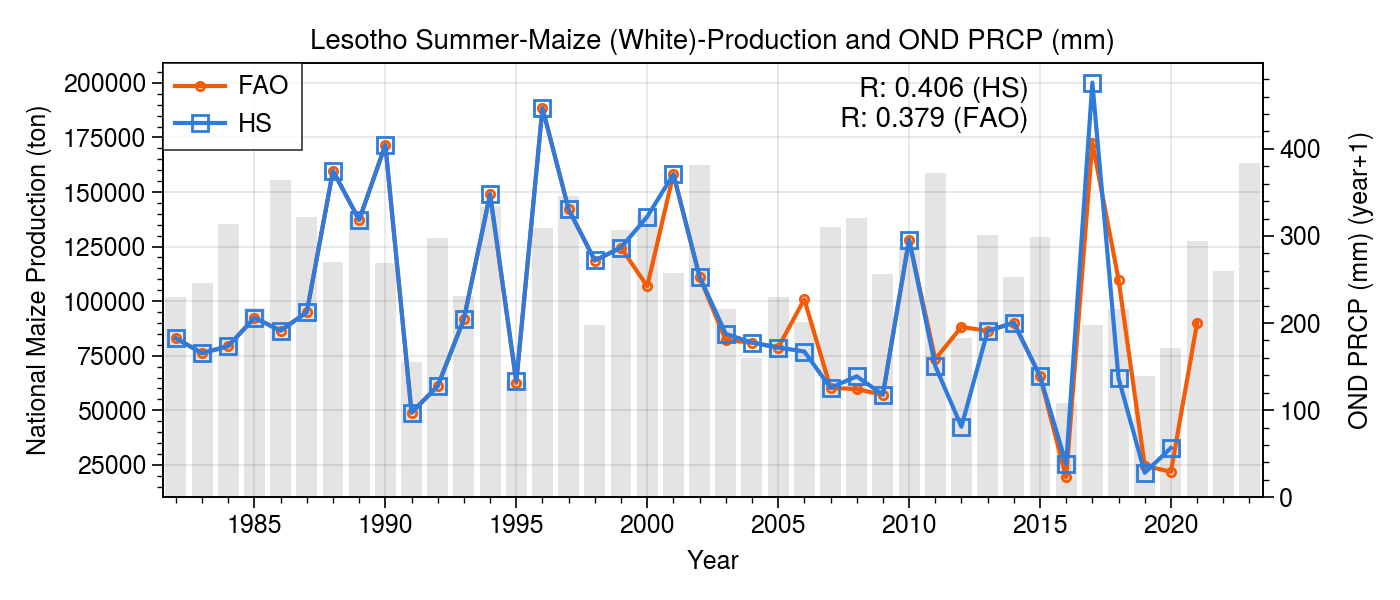

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import proplot as pplot
# Load Crop Data ------------------------------------- #
country_name, season_name, product_name_fdw, product_name_fao,  = 'Lesotho', 'Summer', 'Maize (White)', 'Maize (corn)'
shape_code, prcp_start_month, prcp_season_name, prcp_year_offset = 'LS1980A0', 10, 'OND PRCP (mm)', +1
# HarvestStat
df = pd.read_csv('../public/hvstat_data.csv', index_col=0)
df = df[
    (df['country'] == country_name) &
    (df['season_name'] == season_name) &
    (df['product'].isin([product_name_fdw])) &
    (df['indicator'] == 'production')
].copy()
df['year'] = df['harvest_year']
data_hs = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').squeeze()
# FAO-STAT
df = pd.read_csv('../data/crop/adm_fao_stat.csv', index_col=0)
data_fao = df[
    (df['cnt_name'] == country_name) &
    (df['cpc2_name'] == product_name_fao) &
    (df['indicator'] == 'Production')
].set_index('year')['value']
# Merge
data = pd.concat([data_fao,data_hs], axis=1, keys=['FAO','HS']).sort_index()
data = data.reindex(np.array(range(1982,2024)))
# ---------------------------------------------------- #
# Load precipitation --------------------------------- #
fn = '../data/prcp_chirps-v2.hdf'
prcp_nat = pd.read_hdf(fn)[shape_code].resample('1M').agg('sum')
prcp_nat.index = prcp_nat.index.map(lambda x: x.replace(day=1))
prcp_nat.name = 'PRCP'
prcp_nat.index = prcp_nat.index + pd.DateOffset(years=prcp_year_offset)
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == prcp_start_month]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = prcp_season_name
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'{season_name}-{product_name_fdw} Correlation:\n{corr_value}')
# ---------------------------------------------------- #
# Comparison with Precipitation ---------------------- #
fig, ax1 = plt.subplots(figsize=(7,3))
fig.set_facecolor('white')
data.plot(ax=ax1, grid=True, markerfacecolor='None',color=['#F55A05','#2C7BDD'])
marker = ['.','s']
for i, line in enumerate(ax1.get_lines()):
    line.set_marker(marker[i])
# years = data.index
# ax1.set_xticks(years)
# ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.set_xlim([data.index[0]-0.5, data.index[-1]+0.5])
ax1.set_xlabel('Year')
ax1.set_ylabel('National Maize Production (ton)')
ax1.patch.set_facecolor('white')
# Precipitation
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label + ' (year+%d)'%prcp_year_offset, labelpad=10)
ax2.grid(False)
ax1.set_zorder(1)  
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(loc='upper left')
ax1.annotate(
    'R: %.3f (HS)\nR: %.3f (FAO)' % (corr_value.loc['HS','PRCP'], corr_value.loc['FAO','PRCP']), 
    xy=(0.8, 1.0), xycoords='axes fraction', fontsize=10,
    xytext=(-5, -5), textcoords='offset points',
    ha='right', va='top'
)
title = f'{country_name} {season_name}-{product_name_fdw}-Production and {prcp_label}'
ax1.set_title(title)
fig.tight_layout()
plt.show()
# ---------------------------------------------------- #